Generat data for plots illustrating how the magnetisation of each block varies as we increase the field gradient $g$.

Created on: 20/02/21

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import random
import itertools
import matplotlib
from scipy import stats
import math

from ising_block_level_influence import N_Block_sbm_class as NBlock
from ising_block_level_influence import projection_simplex as proj
from ising_block_level_influence import mean_field_IIM
from spatial_spin_monte_carlo import spatial_spin_monte_carlo as Spins
import Pokec_processing as  PokProc

from pokec_utils import *

In [ ]:
graph = nx.read_graphml('Data/Bratislava_graph.graphml')
beta_c = Spins.crit_beta_sparse(graph)
bratislava_profiles = pd.read_csv("Data/bratislava_profiles.csv")
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
block_data = pd.read_csv('Data/block_info.csv',converters={'Block' : ast.literal_eval})
mean_block_ages = list(block_data['average_age'])
block_sizes = list(block_data['block_size'])
block_names = list(block_data['block_name'])
block_data['age_group'] = [ 'ages_' + k.split('_')[-1] for k in list(block_data['block_name'])]
block_data.head()

In [ ]:
def linear_field(x : np.ndarray,gradient :float) :
    return gradient*x
#Scale ages to [-1,1]:
rescaled_ages = [ (k-np.mean(mean_block_ages))/(max(mean_block_ages)-min(mean_block_ages)) for k in mean_block_ages ]

In [ ]:
bratislava_profiles_indices = bratislava_profiles.reset_index()
groups = [ bratislava_profiles_indices.loc[bratislava_profiles_indices['block']==block] for block in block_names]
groups_node_ids = [list(k['index']) for k in groups]

In [ ]:
def check_group(input_val,group_label) :
    if input_val == group_label :
        return 1.0
    else :
        return 0.0
    
def mean_and_se(values) :
    return f"{np.mean(values)} +/- {stats.sem(values)} "

#Seed the random number generators:
seed = 1
random.seed(seed)
np.random.seed(seed)

Field_Budget = 2500.0
T=10000
T_Burn = 2*300000
Samples = 15
sample_frac = 1.0 # for snapshot control
eval_data = pd.DataFrame()
control_data = pd.DataFrame()

init_sign=-1.0

#beta_factor_vals = [1.0,3.0,5.0,7.0,9.0]
beta_factor_vals=[8.0]
#grad_vals =  np.arange(-10.0,12.0,2.0)
#grad_vals =  np.arange(0,20.0,1.0)

grad_vals =  np.arange(-10.0,11.0,1.0)

beta_factor=8.0
#grad_vals=[5.0]

relab_graph = nx.relabel.convert_node_labels_to_integers(graph)

block_mag_data=pd.DataFrame()

for gradient in tqdm.tqdm_notebook(grad_vals) : 
    age_field = [linear_field(a,gradient) for a in rescaled_ages ]
    age_field_map = {k:j for k,j in zip(list(block_data['age_group']),age_field)}
    background_field = np.asarray([age_field_map[k] for k in list(bratislava_profiles['age_group'])])
    
    initial_state = init_sign*np.ones(len(graph))
    #Run_MonteCarlo_Average(relab_graph, T, beta_factor,beta_c, T_Burn=T_Burn,addition_control=None,sampling_method="Metropolis",full_graph_field=background_field,initial_state=initial_state)
    block_mags = Run_MonteCarlo_Block(relab_graph,
                                      groups_node_ids ,
                                      T, beta_factor,
                                      beta_c, T_Burn=T_Burn,
                                      addition_control=None,
                                      sampling_method="Metropolis",
                                      initial_state=initial_state,
                                      full_graph_field=background_field)
    
    block_mag_data=block_mag_data.append(pd.DataFrame({'block':[int(k) for k in range(len(block_mags[-1]))],
                                                       'gradient':gradient*np.ones(len(block_mags[-1])),
                                                          'mag':block_mags[-1],
                                                      'background_field':age_field}))
    
    
    

In [ ]:
# get the ages and regions seperately
block_mag_data=block_mag_data.merge(block_data.rename(columns={'Unnamed: 0':'block'}),on='block',how='left')
block_mag_data.head()

In [ ]:
block_mag_data.to_csv(f"Data/block_magnetisations_{init_sign}".replace('.','-') +".csv")

,Unnamed: 0,block,gradient,mag,background_field,block_name,block_size,average_age,age_group
0,0,0,-10.0,0.171799,3.577236,Okolie_ages_1-17,1234,9.0,ages_1-17
1,1,1,-10.0,-0.234657,1.869919,Okolie_ages_18-21,1939,19.5,ages_18-21
2,2,2,-10.0,-0.384274,0.975610,Okolie_ages_22-28,3154,25.0,ages_22-28
3,3,3,-10.0,-0.995951,-6.422764,Okolie_ages_29-112,3458,70.5,ages_29-112
4,4,4,-10.0,0.234621,3.577236,Petrzalka_ages_1-17,1398,9.0,ages_1-17


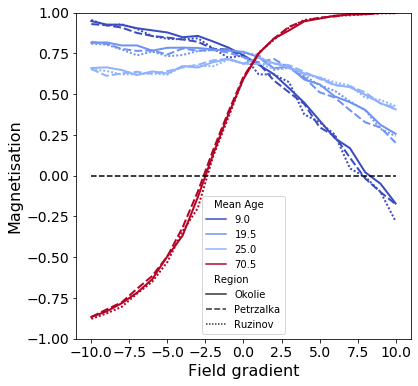

In [14]:
import seaborn as sns

init_sign=1.0
df=pd.read_csv(f"Data/block_magnetisations_{init_sign}".replace('.','-') +".csv")
df['region']=df['block_name'].apply(lambda x : x.split('_')[0])
df=df.rename(columns={'average_age':'Mean Age','region':'Region'})

grad_vals =  np.arange(-10.0,11.0,1.0)


fig,ax=plt.subplots(figsize=(6,6))
#sns.scatterplot(data=df,x='gradient',y='mag',hue='average_age',palette='tab20',style='region')
sns.lineplot(data=df,x='gradient',y='mag',hue='Mean Age',palette='coolwarm',style='Region',lw=2.0)
plt.plot(grad_vals,np.zeros(len(grad_vals)),'k--')
plt.ylim(-1,1)
if init_sign==-1.0:
    plt.legend(ncol=2,loc='upper left',fontsize=14)

plt.xlabel("Field gradient",fontsize=16)
plt.ylabel("Magnetisation",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(f"Plots/Pokec_block_mags_{init_sign}".replace('.','-')+".jpg")

In [ ]:
init_sign

In [ ]:
plt.imshow( np.cov(np.asarray(block_mags).T) )

In [ ]:
init_sign